In [1]:
import networkx as nx

k = 7      # number of vehicles
n = 25      # number of demand points

depot = 0
dem_points = list(range(1,n+1)) # nodes 1, 2, ..., 20

G = nx.complete_graph(n+1,nx.DiGraph())

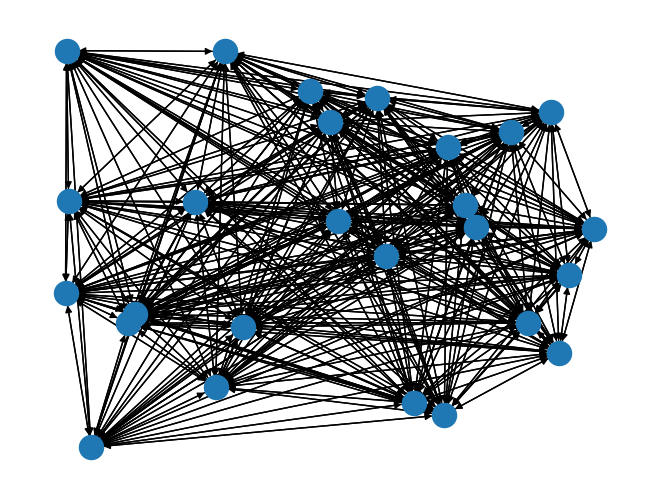

In [2]:
# for convenience, pick the city (x,y)-coordinates at random
import random
my_pos = { i : ( random.random(), random.random() ) for i in dem_points } # pos[i] = (x_i, y_i)

# let's locate the depot in the middle
my_pos[depot] = (0.5, 0.5)

nx.draw(G, pos=my_pos)

In [3]:
# for convenience, suppose that distances are Euclidean
import math
def eucl_dist(x1,y1,x2,y2):
    return math.sqrt( (x1-x2)**2 + (y1-y2)**2 )

for i,j in G.edges:
    (x1,y1) = my_pos[i]
    (x2,y2) = my_pos[j]
    G.edges[i,j]['length'] = eucl_dist(x1,y1,x2,y2)

In [4]:
# suppose each vehicle has capacity 100
Q = 100

# suppose each demand point has demand 20
q = { i : 20 for i in dem_points }

In [5]:
import gurobipy as gp
from gurobipy import GRB

In [6]:
# First, solve a relaxation

m = gp.Model()
x = m.addVars(G.edges,vtype=GRB.BINARY)

m.setObjective( gp.quicksum( G.edges[i,j]['length'] * x[i,j] for i,j in G.edges ), GRB.MINIMIZE )

# Enter each demand point once
m.addConstrs( gp.quicksum( x[i,j] for i in G.predecessors(j) ) == 1 for j in dem_points )

# Leave each demand point once
m.addConstrs( gp.quicksum( x[i,j] for j in G.successors(i) ) == 1 for i in dem_points )

# Leave the depot k times
m.addConstr( gp.quicksum( x[depot,j] for j in G.successors(depot) ) == k )

m.optimize()

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 51 rows, 650 columns and 1275 nonzeros
Model fingerprint: 0x92f60497
Variable types: 0 continuous, 650 integer (650 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+00]
Found heuristic solution: objective 15.5174775
Presolve time: 0.01s
Presolved: 51 rows, 650 columns, 1275 nonzeros
Variable types: 0 continuous, 650 integer (650 binary)

Root relaxation: objective 5.693211e+00, 74 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       5.6932111    5.6932

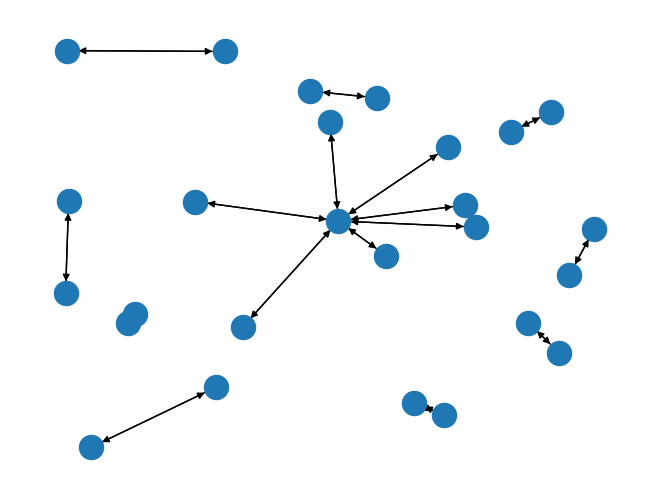

In [7]:
# get the solution and draw it
tour_edges = [ e for e in G.edges if x[e].x > 0.5 ]
nx.draw(G.edge_subgraph(tour_edges), pos=my_pos)

In [8]:
# Add the MTZ variables and constraints, and solve
u = m.addVars( G.nodes )

u[depot].LB = 0
u[depot].UB = 0

for i in dem_points:
    u[i].LB = q[i]
    u[i].UB = Q

c = m.addConstrs( u[i] - u[j] + Q * x[i,j] <= Q - q[j] for i,j in G.edges if j != depot )
m.Params.TimeLimit = 30
m.optimize()

Set parameter TimeLimit to value 30
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 676 rows, 676 columns and 3150 nonzeros
Model fingerprint: 0x806eb773
Variable types: 26 continuous, 650 integer (650 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 8e+01]

MIP start from previous solve did not produce a new incumbent solution

Found heuristic solution: objective 15.9388166
Presolve removed 25 rows and 1 columns
Presolve time: 0.00s
Presolved: 651 rows, 675 columns, 3075 nonzeros
Variable types: 25 continuous, 650 integer (650 binary)

Root relaxation: objective 5.994495e+00, 148 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    

In [9]:
# Try again, using stronger ("lifted") version of these constraints

m.remove(c)  # remove the previous MTZ constraints
q[depot] = 0
m.addConstrs( u[i] - u[j] + Q * x[i,j] + ( Q - q[i] - q[j] ) * x[j,i] <= Q - q[j] for i,j in G.edges if j != depot )

m.reset()    # start solve process from scratch
m.Params.TimeLimit = 30
m.optimize()

Discarded solution information
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 676 rows, 676 columns and 3775 nonzeros
Model fingerprint: 0x877db3c0
Variable types: 26 continuous, 650 integer (650 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 8e+01]
Found heuristic solution: objective 14.2433167
Presolve removed 0 rows and 1 columns
Presolve time: 0.00s
Presolved: 676 rows, 675 columns, 3750 nonzeros
Variable types: 25 continuous, 650 integer (650 binary)

Root relaxation: objective 6.446421e+00, 131 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.44642    0   44   14.24332    6.

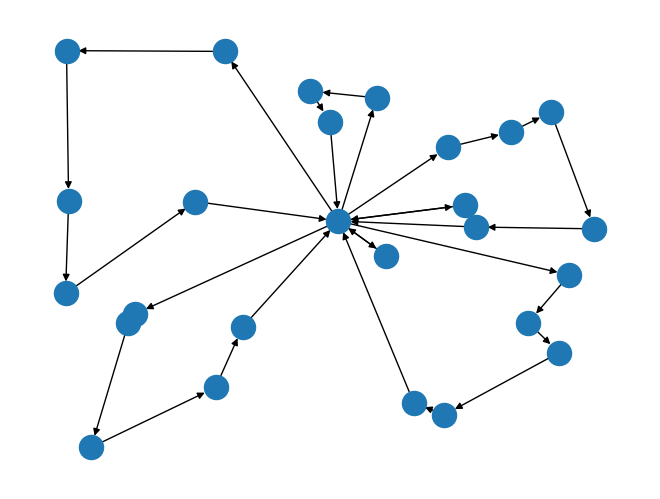

In [10]:
# get the solution and draw it
tour_edges = [ e for e in G.edges if x[e].x > 0.5 ]
nx.draw(G.edge_subgraph(tour_edges), pos=my_pos)